In [1]:
import transformers, torch, tensorflow
from platform import python_version
print("python={}".format(python_version()))
print("transformers=={}\ntorch=={}\ntensorflow=={}\n".
      format(transformers.__version__, torch.__version__, tensorflow.__version__ ))

python=3.7.6
transformers==2.4.1
torch==1.2.0
tensorflow==2.0.0



# How to use BERT? 

BERT [open soruce: pytorch](https://github.com/huggingface/transformers)
> If you want to use `transformers` module, follow this install [guide](https://huggingface.co/transformers/installation.html?highlight=install).  

BERT [document](https://huggingface.co/transformers/index.html#)
> Description of how to use `transformers` module.

## Step1 - Setting
`import` some libraries, and declare basic variables and fucntions in order to load and use **BERT**.


In [2]:
import sys, os, argparse, logging, yaml, pdb
from transformers import BertConfig, BertPreTrainedModel, BertModel, BertTokenizer

parser = argparse.ArgumentParser()
parser.add_argument('--config', default='config.yml', help='read configuration file')
sys.argv = ['-f']
args = parser.parse_args()
with open(args.config, 'r') as f:
    opt = yaml.load(f)
logger = logging.getLogger(__name__)
# setup logging
logging.basicConfig(
    format="%(asctime)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO if opt['verbose'] else logging.WARNING)
logger.info("Hellow World!")

-f:9: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
03/06/2020 18:57:01 - Hellow World!


In [3]:
# opt.keys()

In [4]:
opt['config_name'], opt['cache_dir']

('bert-base-cased', './cache')

### Load configuration object for BERT
Prerequsite argument: 
 * `pretrained_model_name_or_path`: the name of BERT model to use.

Optional:
 * `cache_dir`: we can select cache directory to save. 
   `./cache/b945b69218e98 ... ` file will be saved.
> REF: [pack, unpack](https://wikidocs.net/22801) in python.

In [5]:
config_bert = BertConfig.from_pretrained(pretrained_model_name_or_path=opt['config_name'], 
                                         cache_dir=opt['cache_dir'])
tokenizer = BertTokenizer.from_pretrained(opt['config_name'], do_lower_case=True)

03/06/2020 18:57:02 - loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json from cache at ./cache/b945b69218e98b3e2c95acf911789741307dec43c698d35fad11c1ae28bda352.3d5adf10d3445c36ce131f4c6416aa62e9b58e1af56b97664773f4858a46286e
03/06/2020 18:57:02 - Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "do_sample": false,
  "eos_token_ids": 0,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-12,
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_beams": 1,
  "num_hidden_layers": 12,
  "num_labels":

In [6]:
config_bert.output_hidden_states = True
logger.info("Optional: output all layers' states".format(config_bert.output_hidden_states))

03/06/2020 18:57:03 - Optional: output all layers' states


#### Define a custom model to make use of BERT.

If you wanted, you can make custom model to use BERT. <br>
I want to use BERT embedding for my research, so I added a `linear` layer to train for specific task, later.

In [7]:
import torch.nn as nn
HIDDEN_SIZE_BERT = 768
EMBED_SIZE_WORD = 300

class MyModel(BertPreTrainedModel):
    def __init__(self, config, **kwargs):
        """ Using Bert, define custom Model. 
        [*]: check important parts. """
        super(MyModel, self).__init__(config)
        self.bert = BertModel(config)
        
        # recursively load into the BERT submodule the first time you call pre-trained weights. [*]
        self.init_weights()
        
        # customized layer - these layers' wieghts are not initialized.
        self.linear = nn.Linear(kwargs['hidden_size_bert'], kwargs['embed_size_word'])

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        """ forward step of BERT and pass customed layers.
        input_ids: prerequesite: """
        # pdb.set_trace() # debugging
        hiddens, pooled, hiddens_all = self.bert(input_ids, 
                                                 attention_mask=attention_mask,
                                                 token_type_ids=token_type_ids)
        out = self.linear(hiddens)
        return out, hiddens, hiddens_all # [B, T, D]

model = MyModel.from_pretrained(
    pretrained_model_name_or_path=opt['config_name'], 
    config=config_bert, 
    cache_dir=opt['cache_dir'], 
    hidden_size_bert=HIDDEN_SIZE_BERT,
    embed_size_word=EMBED_SIZE_WORD)

03/06/2020 18:57:04 - loading weights file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-pytorch_model.bin from cache at ./cache/35d8b9d36faaf46728a0192d82bf7d00137490cd6074e8500778afed552a67e5.3fadbea36527ae472139fe84cddaa65454d7429f12d543d80bfc3ad70de55ac2
03/06/2020 18:57:06 - Weights of MyModel not initialized from pretrained model: ['linear.weight', 'linear.bias']
03/06/2020 18:57:06 - Weights from pretrained model not used in MyModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']


### Prepare for Dataset to use

[REF1 - BERT Word Embeddings Tutorials](https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/) <br>
[REF2 - Visualization of BERT Embeddings with t-SNE](https://www.kaggle.com/mateiionita/visualizing-bert-embeddings-with-t-sne)

In [8]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

#### Create a single sentence for being an input of BERT

In [9]:
# Define a new example sentence with multiple meanings of the word "bank"
text = "After stealing money from the bank vault, the bank robber was seen " \
       "fishing on the Mississippi river bank."

# Map the token strings to their vocabulary indeces.
tokens = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text))
input_ids = tokenizer.build_inputs_with_special_tokens(tokens)

# optional - discriminate sentence A or B.
token_type_ids = tokenizer.create_token_type_ids_from_sequences(tokens)
assert len(token_type_ids) == len(input_ids), "single sentence token tpye ids does not matched."

# Convert inputs to PyTorch tensors
input_ids = torch.tensor([input_ids])
token_type_ids = torch.tensor([token_type_ids]) + 1 # becomes all 1
# input_ids, token_type_ids

## Step2 - Get BERT Embedding by forward step

In [10]:
# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()
logger.info("eval mode")

# Predict hidden states features for each layer - speed up inference time.
with torch.no_grad():
    # forward step of a cumstomized model - only output hiddens, not pooled output.
    embed, hiddens, hiddens_all = model(input_ids, token_type_ids=token_type_ids)
logger.info("{}, {}, {}".format(embed.shape, hiddens.shape, len(hiddens_all)))

03/06/2020 18:57:06 - eval mode
03/06/2020 18:57:06 - torch.Size([1, 27, 300]), torch.Size([1, 27, 768]), 13


In [11]:
len(hiddens_all), hiddens_all[0].shape # dim=[#layers, #batches, #tokens, #features]

(13, torch.Size([1, 27, 768]))

In [12]:
# set index for getting wanted information
batch_i, token_i, layer_i = 0, 5, 5
embed_token = hiddens_all[1 + layer_i][batch_i][token_i]
logger.info(embed_token.shape)

03/06/2020 18:57:06 - torch.Size([768])


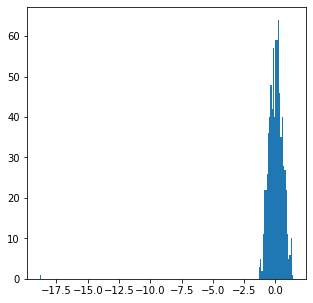

In [13]:
# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(5,5))
plt.hist(embed_token, bins=200)
plt.show()

### Reshape hidden states of BERT-output for analysis.

I will **reshape** BERT-output into `[#tokens, #layers, #features]`

In [14]:
logger.info(torch.stack(hiddens_all[1:], dim=0).shape)
new_embed = torch.squeeze(torch.stack(hiddens_all[1:], dim=0), dim=1)
logger.info(new_embed.shape)
new_embed = new_embed.permute(1,0,2)
logger.info(new_embed.shape) # complete

03/06/2020 18:57:07 - torch.Size([12, 1, 27, 768])
03/06/2020 18:57:07 - torch.Size([12, 27, 768])
03/06/2020 18:57:07 - torch.Size([27, 12, 768])


## Step3 - Create word and sentence vertors 

<div style="background-color:gray"> <summary> <h4>issue</h4> </summary> 
    <p> which layer or combination of layers provides the best representation? In BERT paper, they compared it by F1-scores. </p>
</div>

결론: task 마다 다르다. It depends on the situation... what is your applicaiton?
> the correct pooling strategy and layers used (last four, all, last layer, etc.) is dependent on the application.

### Word Vectors

There are many ways to create word vectors.
1. Concatenate the last 4 layers. Each vector will has length $4 \times 768 = 3072$
2. Summation of the last 4 layers. Each vector will has length $768$
3. Etc.

In [15]:
# Stores the token vectors, with shape [22 x 3,072]
embed_words = []
for embed in new_embed:
    # option 1
#     vec = torch.cat([x for x in embed[-4:]], dim=0)
#     embed_words.append(vec)
    # option 2
    vec = torch.sum(embed[-4:], dim=0)
    embed_words.append(vec)

In [16]:
logger.info("# of tokens: {}, # of dim for each words: {}".format(len(embed_words), embed_words[0].shape))

03/06/2020 18:57:07 - # of tokens: 27, # of dim for each words: torch.Size([768])


### Sentence Vectors

There are also many ways to create word vectors.  
Take one option.
In this blog, I take the average of all tokens' embeddings in the last layer.

In [17]:
embed_sentence = new_embed[1:-1, -1, :] # except first and last token embedding
logger.info(embed_sentence.shape)
embed_sentence = torch.mean(embed_sentence, dim=0)
logger.info(embed_sentence.shape)

03/06/2020 18:57:07 - torch.Size([25, 768])
03/06/2020 18:57:07 - torch.Size([768])


## Step 4 - Analysis of a Case Study

According to this [article](https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/#32-understanding-the-output) at section 3.4, the arthor said that "value of these vectors[sentence and words vectors] are in fact contextually dependent." <br>
Let's look at the different instances of the word “bank” in our example sentence:
>  ''After stealing money from the **bank vault**, the **bank robber** was seen fishing on the Mississippi **river bank**.''

Note that each of the three **bank** has different meaning contextually.

In [18]:
logger.info(text) # recall that text is like this. 
logger.info(input_ids) # tokenized words' ids.

03/06/2020 18:57:07 - After stealing money from the bank vault, the bank robber was seen fishing on the Mississippi river bank.
03/06/2020 18:57:07 - tensor([[  101,  1170, 11569,  1948,  1121,  1103,  3085, 13454,   117,  1103,
          3085,   187, 12809,  3169,  1108,  1562,  5339,  1113,  1103,  5529,
         14788,  9717,  8508,  2186,  3085,   119,   102]])


In [19]:
# extract indices of bank from a given sentence.
indices = [idx for idx, token in enumerate(tokenizer.convert_ids_to_tokens(input_ids.view(-1))) if token=='bank']
logger.info(indices)

03/06/2020 18:57:07 - [6, 10, 24]


### Calculate cosine similarity between the vectors `embed_words` from step 3 

As a human, we can easily notice that 
 * `'bank'` is similar meaning where the `'bank' vault` and the `'bank' robber`.
 * `'bank'` is different meaning where `river 'bank'` and the `'bank' vault` or the `'bank' robber`.

In [23]:
from sklearn.metrics.pairwise import cosine_similarity

logger.info("{}, {}".format(len(embed_words), embed_words[0].shape))

logger.info(tokenizer.convert_ids_to_tokens([input_ids.view(-1)[6].item(), 
                                             input_ids.view(-1)[10].item(), 
                                             input_ids.view(-1)[24].item()]))

score1 = cosine_similarity(embed_words[6].view(1, -1), embed_words[10].view(1, -1)) # similar
score2 = cosine_similarity(embed_words[6].view(1, -1), embed_words[24].view(1, -1)) # different
score3 = cosine_similarity(embed_words[10].view(1, -1), embed_words[24].view(1, -1)) # different
logger.info("score1={}| score2={}| score3={}".format(score1, score2, score3))

03/06/2020 19:12:10 - 27, torch.Size([768])
03/06/2020 19:12:10 - ['bank', 'bank', 'bank']
03/06/2020 19:12:10 - score1=[[0.8953148]]| score2=[[0.7670008]]| score3=[[0.73296183]]


### Report
 According to the author of this article 
> it is worth noting that **word-level similarity comparisons are not appropriate** with BERT embeddings because these embeddings are contextually dependent. This makes direct word-to-word similarity comparisons less valuable.

결론: 문맥에 따라 벡터 표현이 다르므로 **word 간의 similarity 비교**는 큰 의미가 **없다**.

하지만, BERT는 sentence가 같으면 벡터가 같도록 디자인 하였기 때문에 **sentence 사이의 similarity**는 의미가 있을 수 **있다**.